In [ ]:
# uncomment if importing files from Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
%pip install prince
from imblearn.pipeline import Pipeline
import prince

Note: you may need to restart the kernel to use updated packages.


# SVM on Raw Data

In [40]:
# uncomment depending on path of files
# features_path = '/content/drive/MyDrive/final_df.csv'
# raw_data_path = '/content/drive/MyDrive/Rawdata.csv'
features_path = "../data/final_df.csv"
raw_data_path = "../data/Rawdata.csv"

# get data
df_features = pd.read_csv(features_path)
print("Features DataFrame Shape:", df_features.shape)
df_raw = pd.read_csv(raw_data_path, encoding='cp1252')
print("Raw Data DataFrame Shape:", df_raw.shape)
X = df_features
y = df_raw["POLICY3"]

# encode column
df_raw["POLICY3"] = df_raw["POLICY3"].replace({
    "Coronavirus is a serious illness and we should continue social distancing measures until we can safely relax them, but try to re-open as much as possible as soon as it is reasonable safe.": "Somewhat Worried",
    "The disease is a large threat to the health of the nation that will force unconscionable choices if we do not all act together to socially distance for as long as needed even if that means great personal sacrifice.": "Very Worried",
    "This is all an overreaction. The disease is not that serious.  We should relax social distancing measure right away.": "Not Worried"
})
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(df_raw["POLICY3"])
print("Classes after encoding:", encoder.classes_)

# training testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# hyperparameter setting (regularization, kernel, gamma for rbf)
parameter_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

# 5-fold cross validation
svm_clf = SVC()
grid_search = GridSearchCV(svm_clf, parameter_grid, refit=True, verbose=2, cv=5)
grid_search.fit(X_train_scaled, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Estimator:", grid_search.best_estimator_)
grid_predictions = grid_search.predict(X_test_scaled)
accuracy = accuracy_score(y_test, grid_predictions)
print("Test Accuracy:", accuracy)

# training accuracy
svm_clf.fit(X_train_scaled, y_train)
y_train_pred = svm_clf.predict(X_train_scaled)
training_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", training_accuracy)

svm_clf = SVC(kernel='rbf', C=1, gamma=0.01, random_state=42, probability=True)
svm_clf.fit(X_train_scaled, y_train)
y_pred = svm_clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(report)
y_proba = svm_clf.predict_proba(X_test_scaled)
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
print("ROC AUC (macro):", roc_auc)



Features DataFrame Shape: (1211, 84)
Raw Data DataFrame Shape: (1211, 166)
Classes after encoding: ['Not Worried' 'Somewhat Worried' 'Very Worried']
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf;

Model trained on classes: [0 1 2]
Current encoder classes: ['Not Worried' 'Somewhat Worried' 'Very Worried']
Not Worried AUC: 0.74
Somewhat Worried AUC: 0.61
Very Worried AUC: 0.69
Micro-average AUC: 0.76


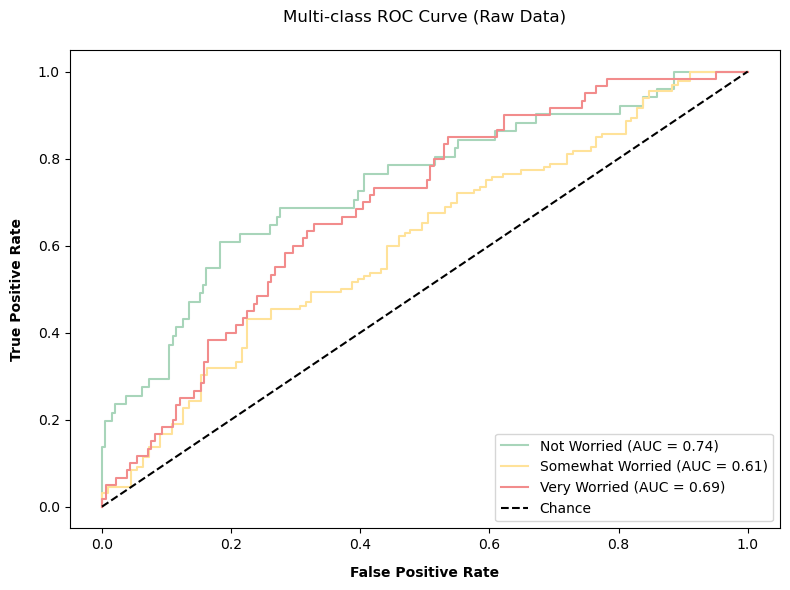

In [32]:
print("Model trained on classes:", svm_clf.classes_)
print("Current encoder classes:", encoder.classes_)

# get labels and colors
labels = list(encoder.inverse_transform(svm_clf.classes_))
colors = ['#A8D5BA', '#FFE299', '#F28C8C']

# one-hot binarize y_test for ROC
classes = np.unique(y_test)
n_classes = len(classes)
y_test_bin = label_binarize(y_test, classes=classes)

# predict probabilities
y_proba = svm_clf.predict_proba(X_test_scaled)

# calculate ROC and AUC
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"{labels[i]} AUC: {roc_auc[i]:.2f}")

# micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print(f"Micro-average AUC: {roc_auc['micro']:.2f}")

# plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')

plt.xlabel("False Positive Rate", fontweight='bold', labelpad=10)
plt.ylabel("True Positive Rate", fontweight='bold', labelpad=10)
plt.title("Multi-class ROC Curve (Raw Data)", pad=20)
plt.legend(loc="lower right", fontsize=10)
plt.tight_layout()
plt.show()

# SVM on MCA (Raw) Data

In [64]:
# uncomment depending on path of files
# mca_components = pd.read_csv("/content/drive/MyDrive/mca_components_new.csv")
mca_components = pd.read_csv("../data/mca_components.csv")
print("MCA Components shape:", mca_components.shape)

MCA Components shape: (1211, 11)


In [ ]:
# uncomment depending on path of files
# df_features = pd.read_csv("/content/drive/MyDrive/final_df.csv")
# df_raw = pd.read_csv("/content/drive/MyDrive/Rawdata.csv", encoding='cp1252')
df_features = pd.read_csv("../data/final_df.csv")
df_raw = pd.read_csv("../data/Rawdata.csv", encoding='cp1252')

df_features = df_features.select_dtypes(include=[np.number]).copy()
df_features.fillna(0, inplace=True)

if df_features.shape[0] < df_raw.shape[0]:
    df_raw = df_raw.iloc[:df_features.shape[0], :]

y = df_raw["POLICY3"]
X_train, X_test, y_train, y_test = train_test_split(
    df_features,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
pipeline = Pipeline([
    ('mca', prince.MCA(random_state=42)),
    ('scaler', StandardScaler()),
    ('svc', SVC(random_state=42))
])

param_grid = {
    'mca__n_components': [11],
    'svc__C': [0.1, 1, 10],
    'svc__gamma': [0.001, 0.01],
    'svc__kernel': ['rbf']
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    error_score='raise' 
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy with MCA:", test_accuracy)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)
y_proba = svm_clf.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
print("\nROC AUC (macro) for MCA-based Model:", roc_auc)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END mca__n_components=11, svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf; total time=   0.1s
[CV] END mca__n_components=11, svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf; total time=   0.2s
[CV] END mca__n_components=11, svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf; total time=   0.1s
[CV] END mca__n_components=11, svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf; total time=   0.2s
[CV] END mca__n_components=11, svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf; total time=   0.2s
[CV] END mca__n_components=11, svc__C=0.1, svc__gamma=0.01, svc__kernel=rbf; total time=   0.3s
[CV] END mca__n_components=11, svc__C=0.1, svc__gamma=0.01, svc__kernel=rbf; total time=   0.6s
[CV] END mca__n_components=11, svc__C=0.1, svc__gamma=0.01, svc__kernel=rbf; total time=   0.3s
[CV] END mca__n_components=11, svc__C=0.1, svc__gamma=0.01, svc__kernel=rbf; total time=   0.2s
[CV] END mca__n_components=11, svc__C=0.1, svc__gamma=0.01, svc__kernel

Baseline Accuracy on MCA Components: 0.5843621399176955
Permutation Importance Results (sorted):
X1: 0.0206
X2: 0.0123
X8: 0.0082
X4: 0.0082
X6: 0.0041
X5: 0.0000
X7: -0.0082
X11: -0.0123
X9: -0.0123
X10: -0.0247
X3: -0.0247


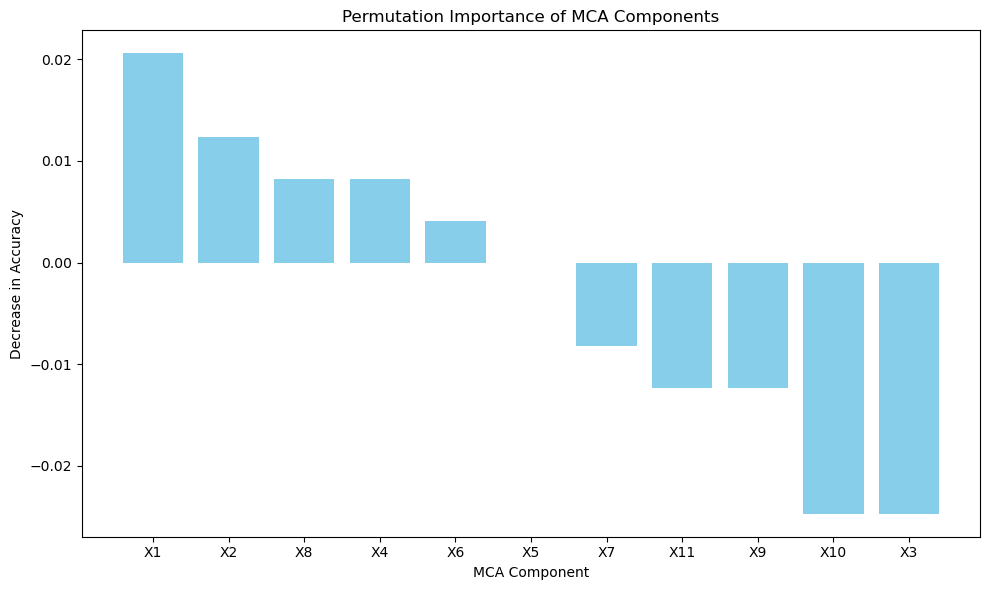

Class mapping:
Class 0: Very Worried
Class 1: Somewhat Worried
Class 2: Not Worried
Very Worried AUC: 0.65
Somewhat Worried AUC: 0.68
Not Worried AUC: 0.76
Micro-average AUC: 0.77


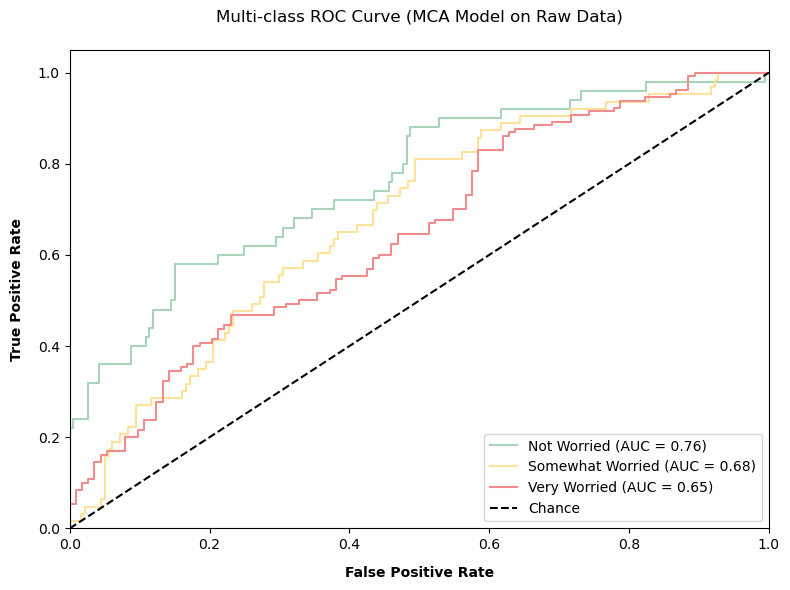

In [66]:
# visuals

mca_step = best_model.named_steps['mca']
scaler_step = best_model.named_steps['scaler']
svc_step = best_model.named_steps['svc']
X_test_mca = mca_step.transform(X_test)
X_test_mca_scaled = scaler_step.transform(X_test_mca)

baseline_accuracy = accuracy_score(y_test, svc_step.predict(X_test_mca_scaled))
print("Baseline Accuracy on MCA Components:", baseline_accuracy)

# permutation importance

n_components = X_test_mca_scaled.shape[1]
decrease_in_accuracy = np.zeros(n_components)

for i in range(n_components):
    X_test_ablation = X_test_mca_scaled.copy()
    col_mean = X_test_ablation[:, i].mean()
    X_test_ablation[:, i] = col_mean
    ablation_accuracy = accuracy_score(y_test, svc_step.predict(X_test_ablation))
    decrease_in_accuracy[i] = baseline_accuracy - ablation_accuracy

component_labels = [f"X{i+1}" for i in range(n_components)]

sorted_idx = np.argsort(decrease_in_accuracy)[::-1]
sorted_decrease = decrease_in_accuracy[sorted_idx]
sorted_labels = [component_labels[i] for i in sorted_idx]

# Print component importance scores for verification
print("Permutation Importance Results (sorted):")
for label, score in zip(sorted_labels, sorted_decrease):
    print(f"{label}: {score:.4f}")
    
plt.figure(figsize=(10, 6))
plt.bar(sorted_labels, sorted_decrease, color='skyblue')
plt.xlabel("MCA Component")
plt.ylabel("Decrease in Accuracy")
plt.title("Permutation Importance of MCA Components")
plt.tight_layout()
plt.show()

# ROC-AUC

# get labels from original data and classes
custom_labels = ["Very Worried", "Somewhat Worried", "Not Worried"]
print("Class mapping:")
for idx, name in enumerate(custom_labels):
    print(f"Class {idx}: {name}")

# binarize for calculations
classes = np.unique(y_test)
n_classes = len(classes)
y_test_bin = label_binarize(y_test, classes=classes)

# get probabilities
y_proba = svm_clf.predict_proba(X_test)

# calculate FPR, TPR, AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"{custom_labels[i]} AUC: {roc_auc[i]:.2f}")

# micro average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print(f"Micro-average AUC: {roc_auc['micro']:.2f}")

# set desired display order for plotting
target_order = ["Not Worried", "Somewhat Worried", "Very Worried"]
colors = ["#A8D5BA", "#FFE299", "#F28C8C"]
label_to_index = {label: i for i, label in enumerate(custom_labels)}

# Plotting
plt.figure(figsize=(8, 6))
for i, label in enumerate(target_order):
    idx = label_to_index[label]
    plt.plot(fpr[idx], tpr[idx], color=colors[i],
             label=f"{label} (AUC = {roc_auc[idx]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Chance")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontweight='bold', labelpad=10)
plt.ylabel("True Positive Rate", fontweight='bold', labelpad=10)
plt.title("Multi-class ROC Curve (MCA Model on Raw Data)", pad=20)
plt.legend(loc="lower right", fontsize=10)
plt.tight_layout()
plt.show()


# SVM on SMOTE Data

In [47]:
# uncomment based on path of files
# smote_df = pd.read_csv("/content/drive/MyDrive/df_smote_with_target.csv")
smote_df = pd.read_csv("../data/df_smote_with_target.csv")
print("SMOTE Data Shape:", smote_df.shape)

SMOTE Data Shape: (1947, 85)


In [48]:
X = smote_df.drop("POLICY3_target", axis=1)
y = smote_df["POLICY3_target"]

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
print("Classes after encoding:")
for idx, name in enumerate(encoder.classes_):
    print(f"Class {idx}: {name}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# hyperparameter grid
svm_clf = SVC(probability=True, random_state=42)
parameter_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(svm_clf, parameter_grid, refit=True, cv=5, verbose=2)
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters on SMOTE data:", grid_search.best_params_)
print("Best Estimator on SMOTE data:", grid_search.best_estimator_)

best_model_smote = grid_search.best_estimator_
y_pred = best_model_smote.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy on SMOTE data:", test_accuracy)

print("Confusion Matrix (SMOTE data):")
print(confusion_matrix(y_test, y_pred))

print("Classification Report (SMOTE data):")
print(classification_report(y_test, y_pred))

# ROC AUC (macro)
y_proba = best_model_smote.predict_proba(X_test_scaled)
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
print("ROC AUC (macro) on SMOTE data:", roc_auc)

Classes after encoding:
Class 0: Coronavirus is a serious illness and we should continue social distancing measures until we can safely relax them, but try to re-open as much as possible as soon as it is reasonable safe.
Class 1: The disease is a large threat to the health of the nation that will force unconscionable choices if we do not all act together to socially distance for as long as needed even if that means great personal sacrifice.
Class 2: This is all an overreaction. The disease is not that serious.  We should relax social distancing measure right away.
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.9s
[CV] END .........................C=0.1, gam

Very Worried AUC: 0.82
Somewhat Worried AUC: 0.85
Not Worried AUC: 0.90
Micro-average AUC: 0.87
Class mapping (SMOTE model):
Class 0: Very Worried
Class 1: Somewhat Worried
Class 2: Not Worried


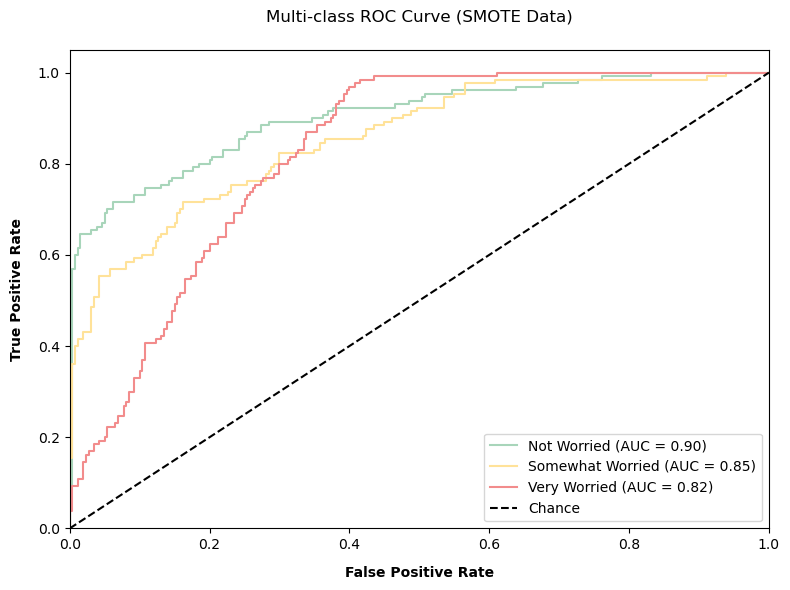

In [50]:
# visuals

custom_labels = ["Very Worried", "Somewhat Worried", "Not Worried"]

# binarize
classes = np.unique(y_test)
n_classes = len(classes)
y_test_bin = label_binarize(y_test, classes=classes)

# probabilities
y_proba = best_model_smote.predict_proba(X_test_scaled)

# calculations
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"{custom_labels[i]} AUC: {roc_auc[i]:.2f}")

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print(f"Micro-average AUC: {roc_auc['micro']:.2f}")

# set target visual order
target_order = ["Not Worried", "Somewhat Worried", "Very Worried"]
colors = ["#A8D5BA", "#FFE299", "#F28C8C"]
print("Class mapping (SMOTE model):")
for idx, name in enumerate(custom_labels):
    print(f"Class {idx}: {name}")
label_to_index = {label: i for i, label in enumerate(custom_labels)}

# plot curves
plt.figure(figsize=(8, 6))
for i, label in enumerate(target_order):
    idx = label_to_index[label]
    plt.plot(fpr[idx], tpr[idx], color=colors[i],
             label=f"{label} (AUC = {roc_auc[idx]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Chance")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontweight='bold', labelpad=10)
plt.ylabel("True Positive Rate", fontweight='bold', labelpad=10)
plt.title("Multi-class ROC Curve (SMOTE Data)", pad=20)
plt.legend(loc="lower right", fontsize=10)
plt.tight_layout()
plt.show()

# SVM on MCA (SMOTE, 0.75) Data

In [53]:
# uncomment based on file path
# file_path ='/content/mca_components_smote.csv'
file_path = "../data/mca_components_smote_75.csv"
mca_components_smote = pd.read_csv(file_path, header=None)
print("Shape:", mca_components_smote.shape)

# uncomment based on file path, is only for target variable
# df_smote_target = pd.read_csv("/content/drive/MyDrive/df_smote_with_target.csv", encoding='cp1252')
df_smote_target = pd.read_csv("../data/df_smote_with_target.csv", encoding='cp1252')
print("SMOTE with target shape:", df_smote_target.shape)

Shape: (1948, 9)
SMOTE with target shape: (1947, 85)


In [55]:
# uncomment based on file path
# X = pd.read_csv("/content/mca_components_smote.csv")
# df_target = pd.read_csv("/content/drive/MyDrive/df_smote_with_target.csv", encoding='cp1252')
X = pd.read_csv("../data/mca_components_smote_75.csv")
df_target = pd.read_csv("../data/df_smote_with_target.csv", encoding='cp1252')
print("MCA Components (SMOTE) shape:", X.shape)
print("SMOTE with Target Data shape:", df_target.shape)
y = df_target["POLICY3_target"]

if X.shape[0] != df_target.shape[0]:
    min_rows = min(X.shape[0], df_target.shape[0])
    X = X.iloc[:min_rows, :]
    y = y.iloc[:min_rows]
    print("Data aligned to", min_rows, "rows.")

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
print("Classes after encoding:")
for idx, class_name in enumerate(encoder.classes_):
    print(f"Class {idx}: {class_name}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_clf = SVC(probability=True, random_state=42)
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.001],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(svm_clf, param_grid, cv=5, verbose=2, refit=True)
grid_search.fit(X_train_scaled, y_train)
print("Best Parameters (SMOTE+MCA):", grid_search.best_params_)
best_model_smote_mca = grid_search.best_estimator_

y_pred = best_model_smote_mca.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy (SMOTE+MCA):", test_accuracy)
print("Confusion Matrix (SMOTE+MCA):")
print(confusion_matrix(y_test, y_pred))
print("Classification Report (SMOTE+MCA):")
print(classification_report(y_test, y_pred))


y_proba = best_model_smote_mca.predict_proba(X_test_scaled)
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
print("ROC AUC (macro) (SMOTE+MCA):", roc_auc)

MCA Components (SMOTE) shape: (1947, 9)
SMOTE with Target Data shape: (1947, 85)
Classes after encoding:
Class 0: Coronavirus is a serious illness and we should continue social distancing measures until we can safely relax them, but try to re-open as much as possible as soon as it is reasonable safe.
Class 1: The disease is a large threat to the health of the nation that will force unconscionable choices if we do not all act together to socially distance for as long as needed even if that means great personal sacrifice.
Class 2: This is all an overreaction. The disease is not that serious.  We should relax social distancing measure right away.
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.3s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.3s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.3s
[CV] END ......................C=0.1, gamma=0

Very Worried AUC: 0.76
Somewhat Worried AUC: 0.77
Not Worried AUC: 0.79
Micro-average AUC: 0.78
Class mapping (SMOTE + MCA model):
Class 0: Very Worried
Class 1: Somewhat Worried
Class 2: Not Worried


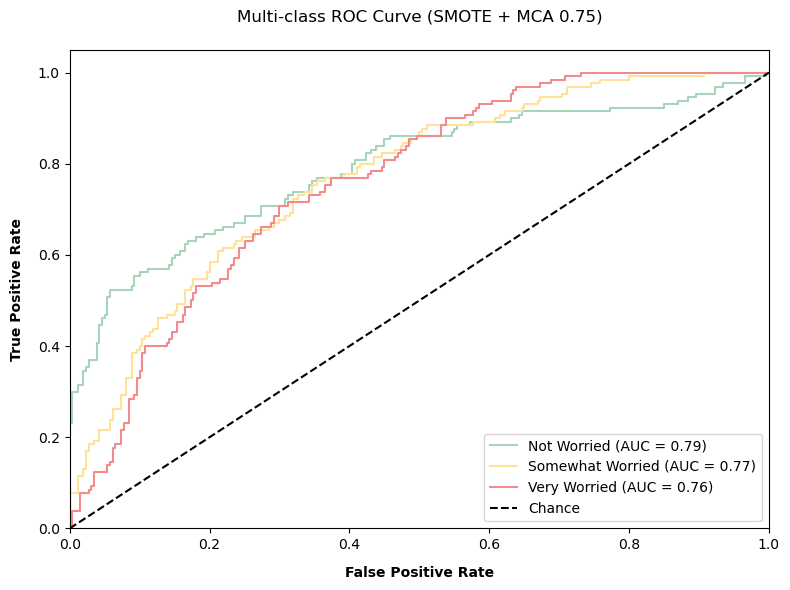

In [ ]:
# visuals

custom_labels = ["Very Worried", "Somewhat Worried", "Not Worried"]

classes = np.unique(y_test)
n_classes = len(classes)
y_test_bin = label_binarize(y_test, classes=classes)

y_proba = best_model_smote_mca.predict_proba(X_test_scaled)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"{custom_labels[i]} AUC: {roc_auc[i]:.2f}")

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print(f"Micro-average AUC: {roc_auc['micro']:.2f}")

# use desired visual order and color palette to plot

target_order = ["Not Worried", "Somewhat Worried", "Very Worried"]
colors = ["#A8D5BA", "#FFE299", "#F28C8C"]
print("Class mapping (SMOTE + MCA model):")
for idx, name in enumerate(custom_labels):
    print(f"Class {idx}: {name}")

label_to_index = {label: i for i, label in enumerate(custom_labels)}

# Plot in target order
plt.figure(figsize=(8, 6))
for i, label in enumerate(target_order):
    idx = label_to_index[label]
    plt.plot(fpr[idx], tpr[idx], color=colors[i],
             label=f"{label} (AUC = {roc_auc[idx]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Chance")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontweight='bold', labelpad=10)
plt.ylabel("True Positive Rate", fontweight='bold', labelpad=10)
plt.title("Multi-class ROC Curve (SMOTE + MCA 0.75)", pad=20)
plt.legend(loc="lower right", fontsize=10)
plt.tight_layout()
plt.show()


# SVM on MCA (SMOTE, 0.95) Data

In [58]:
# uncomment based on file path
file_path = "../data/mca_components_smote_95.csv"
mca_components_smote = pd.read_csv(file_path, header=None)
print("Shape:", mca_components_smote.shape)

df_smote_target = pd.read_csv("../data/df_smote_with_target.csv", encoding='cp1252')
print("SMOTE with target shape:", df_smote_target.shape)

Shape: (1948, 36)
SMOTE with target shape: (1947, 85)


In [59]:
# uncomment based on file path
# df_target = pd.read_csv("/content/drive/MyDrive/df_smote_with_target.csv", encoding='cp1252')
X = pd.read_csv("../data/mca_components_smote_95.csv")
df_target = pd.read_csv("../data/df_smote_with_target.csv", encoding='cp1252')
print("MCA Components (SMOTE) shape:", X.shape)
print("SMOTE with Target Data shape:", df_target.shape)
y = df_target["POLICY3_target"]

if X.shape[0] != df_target.shape[0]:
    min_rows = min(X.shape[0], df_target.shape[0])
    X = X.iloc[:min_rows, :]
    y = y.iloc[:min_rows]
    print("Data aligned to", min_rows, "rows.")

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
print("Classes after encoding:")
for idx, class_name in enumerate(encoder.classes_):
    print(f"Class {idx}: {class_name}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_clf = SVC(probability=True, random_state=42)
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.001],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(svm_clf, param_grid, cv=5, verbose=2, refit=True)
grid_search.fit(X_train_scaled, y_train)
print("Best Parameters (SMOTE+MCA):", grid_search.best_params_)
best_model_smote_mca = grid_search.best_estimator_

y_pred = best_model_smote_mca.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy (SMOTE+MCA):", test_accuracy)
print("Confusion Matrix (SMOTE+MCA):")
print(confusion_matrix(y_test, y_pred))
print("Classification Report (SMOTE+MCA):")
print(classification_report(y_test, y_pred))


y_proba = best_model_smote_mca.predict_proba(X_test_scaled)
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
print("ROC AUC (macro) (SMOTE+MCA):", roc_auc)

MCA Components (SMOTE) shape: (1947, 36)
SMOTE with Target Data shape: (1947, 85)
Classes after encoding:
Class 0: Coronavirus is a serious illness and we should continue social distancing measures until we can safely relax them, but try to re-open as much as possible as soon as it is reasonable safe.
Class 1: The disease is a large threat to the health of the nation that will force unconscionable choices if we do not all act together to socially distance for as long as needed even if that means great personal sacrifice.
Class 2: This is all an overreaction. The disease is not that serious.  We should relax social distancing measure right away.
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.5s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.5s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.5s
[CV] END ......................C=0.1, gamma=

Very Worried AUC: 0.76
Somewhat Worried AUC: 0.84
Not Worried AUC: 0.88
Micro-average AUC: 0.83
Class mapping (SMOTE + MCA model):
Class 0: Very Worried
Class 1: Somewhat Worried
Class 2: Not Worried


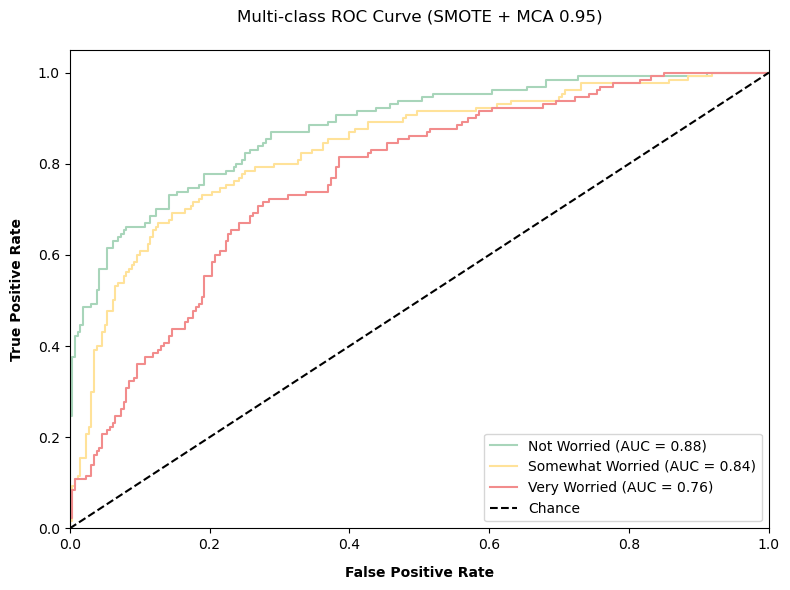

In [60]:
# visuals

custom_labels = ["Very Worried", "Somewhat Worried", "Not Worried"]

classes = np.unique(y_test)
n_classes = len(classes)
y_test_bin = label_binarize(y_test, classes=classes)

y_proba = best_model_smote_mca.predict_proba(X_test_scaled)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"{custom_labels[i]} AUC: {roc_auc[i]:.2f}")

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print(f"Micro-average AUC: {roc_auc['micro']:.2f}")

# use desired visual order and color palette to plot

target_order = ["Not Worried", "Somewhat Worried", "Very Worried"]
colors = ["#A8D5BA", "#FFE299", "#F28C8C"]
print("Class mapping (SMOTE + MCA model):")
for idx, name in enumerate(custom_labels):
    print(f"Class {idx}: {name}")

label_to_index = {label: i for i, label in enumerate(custom_labels)}

# Plot in target order
plt.figure(figsize=(8, 6))
for i, label in enumerate(target_order):
    idx = label_to_index[label]
    plt.plot(fpr[idx], tpr[idx], color=colors[i],
             label=f"{label} (AUC = {roc_auc[idx]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Chance")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontweight='bold', labelpad=10)
plt.ylabel("True Positive Rate", fontweight='bold', labelpad=10)
plt.title("Multi-class ROC Curve (SMOTE + MCA 0.95)", pad=20)
plt.legend(loc="lower right", fontsize=10)
plt.tight_layout()
plt.show()
